# College Football Playoff Predictor

[Write an introduction explaining what this project does and why it's interesting. Mention the transition from 4-team to 12-team playoff format.]

**Data Source:** College football team statistics from [Sports Reference](https://www.sports-reference.com/cfb/)

## Import Libraries

In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report

## Load and Prepare Data

[Explain what data you're loading and how you're structuring it. Mention the time range (2014-2025) and what each feature represents.]

In [2]:
# Define power conferences by era
power_5 = ['Big Ten', 'Big 12', 'SEC', 'ACC', 'Pac-12']
power_4 = ['Big Ten', 'Big 12', 'SEC', 'ACC']

dfs = []

# Load data for each season
for yr in range(2014, 2025 + 1):
    standings_raw = pd.read_csv(f"sports-reference-data/sr-standings-{yr}.csv")

    year_df = pd.DataFrame({
        'Year': yr,
        'Team': standings_raw['School'],
        'Conference': standings_raw['Conf'],
        'Wins': standings_raw['W'],
        'Losses': standings_raw['L'],
        'SoS': standings_raw['SOS'],  # Strength of Schedule
    })

    # Clean conference names (remove division info in parentheses)
    year_df['Conference'] = year_df['Conference'].str.replace(r'\s*\(.*\)', '', regex=True)
    
    # Calculate total games played
    year_df['Games'] = year_df['Wins'] + year_df['Losses']
    
    # Mark power conference teams (Pac-12 only exists before 2024)
    year_df['Power_Conf'] = year_df['Conference'].isin(
        power_5 if yr < 2024 else power_4
    ).astype(int)
    
    # Find ranking column (column name varies by year)
    possible_rank_cols = ['AP Rank', 'AP Curr']
    rank_series = next(
        (standings_raw[c] for c in possible_rank_cols if c in standings_raw.columns),
        None
    )

    # Binary: was team ranked at end of season?
    year_df['Ranked'] = rank_series.notna().astype(int) if rank_series is not None else 0

    dfs.append(year_df)

# Combine all years into single dataframe
df = pd.concat(dfs, ignore_index=True)

# Calculate win percentage
df['Win_Pct'] = df['Wins'] / df['Games']

df.head()

,Year,Team,Conference,Wins,Losses,SoS,Games,Power_Conf,Ranked,Win_Pct
0,2014,Florida State,ACC,13,1,5.13,14,1,1,0.928571
1,2014,Clemson,ACC,10,3,2.86,13,1,1,0.769231
2,2014,Louisville,ACC,9,4,3.22,13,1,1,0.692308
3,2014,Boston College,ACC,7,6,2.35,13,1,0,0.538462
4,2014,North Carolina State,ACC,8,5,1.25,13,1,0,0.615385


## Create Target Variables

[Explain what each target variable represents and how you labeled the data.]

In [15]:
# Initialize target variables
df['Conf_Champ'] = 0
df['Conf_Finalist'] = 0
df['Final_4'] = 0
df['Final_12'] = 0
df['National_Champ'] = 0

df.head()

,Year,Team,Conference,Wins,Losses,SoS,Games,Power_Conf,Ranked,Win_Pct,Final_4,National_Champ,Conf_Champ,Conf_Finalist,Final_12
0,2014,Florida State,ACC,13,1,5.13,14,1,1,0.928571,0,0,0,0,0
1,2014,Clemson,ACC,10,3,2.86,13,1,1,0.769231,0,0,0,0,0
2,2014,Louisville,ACC,9,4,3.22,13,1,1,0.692308,0,0,0,0,0
3,2014,Boston College,ACC,7,6,2.35,13,1,0,0.538462,0,0,0,0,0
4,2014,North Carolina State,ACC,8,5,1.25,13,1,0,0.615385,0,0,0,0,0


In [16]:
# Define playoff results for all years
playoff_results = {
    2014: {'Ohio State': 'Champion', 'Oregon': 'Final', 'Alabama': 'Semifinal', 'Florida State': 'Semifinal'},
    2015: {'Alabama': 'Champion', 'Clemson': 'Final', 'Oklahoma': 'Semifinal', 'Michigan State': 'Semifinal'},
    2016: {'Clemson': 'Champion', 'Alabama': 'Final', 'Ohio State': 'Semifinal', 'Washington': 'Semifinal'},
    2017: {'Alabama': 'Champion', 'Georgia': 'Final', 'Oklahoma': 'Semifinal', 'Clemson': 'Semifinal'},
    2018: {'Clemson': 'Champion', 'Alabama': 'Final', 'Notre Dame': 'Semifinal', 'Oklahoma': 'Semifinal'},
    2019: {'LSU': 'Champion', 'Clemson': 'Final', 'Ohio State': 'Semifinal', 'Oklahoma': 'Semifinal'},
    2020: {'Alabama': 'Champion', 'Ohio State': 'Final', 'Clemson': 'Semifinal', 'Notre Dame': 'Semifinal'},
    2021: {'Georgia': 'Champion', 'Alabama': 'Final', 'Michigan': 'Semifinal', 'Cincinnati': 'Semifinal'},
    2022: {'Georgia': 'Champion', 'TCU': 'Final', 'Michigan': 'Semifinal', 'Ohio State': 'Semifinal'},
    2023: {'Michigan': 'Champion', 'Washington': 'Final', 'Alabama': 'Semifinal', 'Texas': 'Semifinal'},
    
    # 12-team playoff (2024 - first year of new format)
    2024: {
        'Ohio State': 'Champion', 'Notre Dame': 'Final',
        'Penn State': 'Semifinal', 'Texas': 'Semifinal',
        'Georgia': 'Quarterfinal', 'Oregon': 'Quarterfinal', 
        'Boise State': 'Quarterfinal', 'Arizona State': 'Quarterfinal',
        'Tennessee': 'First Round', 'Indiana': 'First Round', 
        'SMU': 'First Round', 'Clemson': 'First Round'
    },
    
    # 12-team playoff (2025)
    2025: {
        'Ohio State': 'Champion', 'Notre Dame': 'Final',
        'Texas': 'Semifinal', 'Penn State': 'Semifinal',
        'Georgia': 'Quarterfinal', 'Oregon': 'Quarterfinal', 
        'Boise State': 'Quarterfinal', 'Arizona State': 'Quarterfinal',
        'Tennessee': 'First Round', 'Indiana': 'First Round', 
        'SMU': 'First Round', 'Clemson': 'First Round'
    }
}

# NY6 bowl participants (2014-2023) - these count as Final_12
ny6_bowls = {
    2014: ['Boise State', 'Arizona', 'TCU', 'Ole Miss', 'Georgia Tech', 'Mississippi State',
           'Michigan State', 'Baylor', 'Oregon', 'Florida State', 'Ohio State', 'Alabama'],
    2015: ['Houston', 'Florida State', 'Clemson', 'Oklahoma', 'Alabama', 'Michigan State',
           'Ohio State', 'Notre Dame', 'Stanford', 'Iowa', 'Ole Miss', 'Oklahoma State'],
    2016: ['Florida State', 'Michigan', 'Alabama', 'Washington', 'Clemson', 'Ohio State',
           'Wisconsin', 'Western Michigan', 'USC', 'Penn State', 'Oklahoma', 'Auburn'],
    2017: ['Ohio State', 'USC', 'Penn State', 'Washington', 'Wisconsin', 'Miami',
           'UCF', 'Auburn', 'Georgia', 'Oklahoma', 'Alabama', 'Clemson'],
    2018: ['Florida', 'Michigan', 'Clemson', 'Notre Dame', 'Alabama', 'Oklahoma',
           'LSU', 'UCF', 'Ohio State', 'Washington', 'Texas', 'Georgia'],
    2019: ['Penn State', 'Memphis', 'LSU', 'Oklahoma', 'Clemson', 'Ohio State',
           'Florida', 'Virginia', 'Oregon', 'Wisconsin', 'Georgia', 'Baylor'],
    2020: ['Oklahoma', 'Florida', 'Georgia', 'Cincinnati', 'Alabama', 'Notre Dame',
           'Ohio State', 'Clemson', 'Texas A&M', 'North Carolina', 'Iowa State', 'Oregon'],
    2021: ['Michigan State', 'Pitt', 'Alabama', 'Cincinnati', 'Georgia', 'Michigan',
           'Oklahoma State', 'Notre Dame', 'Ohio State', 'Utah', 'Baylor', 'Ole Miss'],
    2022: ['Tennessee', 'Clemson', 'Alabama', 'Kansas State', 'TCU', 'Michigan',
           'Georgia', 'Ohio State', 'Tulane', 'USC', 'Penn State', 'Utah'],
    2023: ['Missouri', 'Ohio State', 'Ole Miss', 'Penn State', 'Georgia', 'Florida State',
           'Oregon', 'Liberty', 'Michigan', 'Alabama', 'Washington', 'Texas'],
}

# Conference Championships
conf_data = {
    2014: {
        'champs': ['Florida State', 'Ohio State', 'Alabama', 'Baylor', 'TCU', 'Oregon', 'UCF', 'Marshall', 'Northern Illinois', 'Boise State'],
        'finalists': ['Florida State', 'Georgia Tech', 'Ohio State', 'Wisconsin', 'Alabama', 'Missouri', 'Oregon', 'Arizona', 'Marshall', 'Louisiana Tech', 'Northern Illinois', 'Bowling Green', 'Boise State', 'Fresno State']
    },
    2015: {
        'champs': ['Clemson', 'Michigan State', 'Alabama', 'Oklahoma', 'Stanford', 'Houston', 'Western Kentucky', 'Bowling Green', 'San Diego State'],
        'finalists': ['North Carolina', 'Clemson', 'Michigan State', 'Iowa', 'Alabama', 'Florida', 'Stanford', 'USC', 'Houston', 'Temple', 'Western Kentucky', 'Southern Miss', 'Bowling Green', 'Northern Illinois', 'San Diego State', 'Air Force']
    },
    2016: {
        'champs': ['Clemson', 'Penn State', 'Alabama', 'Oklahoma', 'Washington', 'Temple', 'Western Kentucky', 'Western Michigan', 'San Diego State'],
        'finalists': ['Clemson', 'Virginia Tech', 'Penn State', 'Wisconsin', 'Alabama', 'Florida', 'Washington', 'Colorado', 'Temple', 'Navy', 'Western Kentucky', 'Louisiana Tech', 'Western Michigan', 'Ohio', 'San Diego State', 'Wyoming']
    },
    2017: {
        'champs': ['Clemson', 'Ohio State', 'Georgia', 'TCU', 'USC', 'UCF', 'Florida Atlantic', 'Toledo', 'Boise State'],
        'finalists': ['Clemson', 'Miami', 'Ohio State', 'Wisconsin', 'Georgia', 'Auburn', 'Oklahoma', 'TCU', 'USC', 'Stanford', 'UCF', 'Memphis', 'Florida Atlantic', 'North Texas', 'Toledo', 'Akron', 'Boise State', 'Fresno State']
    },
    2018: {
        'champs': ['Clemson', 'Ohio State', 'Alabama', 'Oklahoma', 'Washington', 'UCF', 'UAB', 'Northern Illinois', 'Fresno State', 'Appalachian State'],
        'finalists': ['Clemson', 'Pittsburgh', 'Ohio State', 'Northwestern', 'Alabama', 'Georgia', 'Oklahoma', 'Texas', 'Washington', 'Utah', 'UCF', 'Memphis', 'UAB', 'Middle Tennessee', 'Northern Illinois', 'Buffalo', 'Fresno State', 'Boise State', 'Appalachian State', 'Louisiana']
    },
    2019: {
        'champs': ['Clemson', 'Ohio State', 'LSU', 'Oklahoma', 'Oregon', 'Memphis', 'Florida Atlantic', 'Miami (OH)', 'Boise State', 'Appalachian State'],
        'finalists': ['Clemson', 'Virginia', 'Ohio State', 'Wisconsin', 'LSU', 'Georgia', 'Oklahoma', 'Baylor', 'Oregon', 'Utah', 'Memphis', 'Cincinnati', 'Florida Atlantic', 'UAB', 'Miami (OH)', 'Central Michigan', 'Boise State', 'Hawaii', 'Appalachian State', 'Louisiana']
    },
    2020: {
        'champs': ['Clemson', 'Ohio State', 'Alabama', 'Oklahoma', 'Oregon', 'Cincinnati', 'UAB', 'Ball State', 'San Jose State', 'Coastal Carolina', 'Louisiana'],
        'finalists': ['Clemson', 'Notre Dame', 'Northwestern', 'Ohio State', 'Alabama', 'Florida', 'Oklahoma', 'Iowa State', 'Oregon', 'USC', 'Cincinnati', 'Tulsa', 'UAB', 'Marshall', 'Ball State', 'Buffalo', 'San Jose State', 'Boise State']
    },
    2021: {
        'champs': ['Pittsburgh', 'Michigan', 'Alabama', 'Baylor', 'Utah', 'Cincinnati', 'UTSA', 'Northern Illinois', 'Utah State', 'Louisiana'],
        'finalists': ['Pittsburgh', 'Wake Forest', 'Michigan', 'Iowa', 'Georgia', 'Alabama', 'Baylor', 'Oklahoma State', 'Utah', 'Oregon', 'Cincinnati', 'Houston', 'UTSA', 'Western Kentucky', 'Northern Illinois', 'Kent State', 'Utah State', 'San Diego State', 'Louisiana', 'Appalachian State']
    },
    2022: {
        'champs': ['Clemson', 'Michigan', 'Georgia', 'Kansas State', 'Utah', 'Tulane', 'Toledo', 'UTSA', 'Fresno State', 'Troy'],
        'finalists': ['Clemson', 'North Carolina', 'Michigan', 'Purdue', 'Georgia', 'LSU', 'Kansas State', 'TCU', 'Utah', 'USC', 'Tulane', 'UCF', 'Ohio', 'Toledo', 'UTSA', 'North Texas', 'Boise State', 'Fresno State', 'Coastal Carolina', 'Troy']
    },
    2023: {
        'champs': ['Florida State', 'Michigan', 'Georgia', 'Texas', 'Washington', 'SMU', 'Liberty', 'Miami (OH)', 'Boise State', 'Troy'],
        'finalists': ['Louisville', 'Florida State', 'Michigan', 'Iowa', 'Georgia', 'Alabama', 'Oklahoma State', 'Texas', 'Washington', 'Oregon', 'SMU', 'Tulane', 'Liberty', 'New Mexico State', 'Miami (OH)', 'Toledo', 'UNLV', 'Boise State', 'Appalachian State', 'Troy']
    },
    2024: {
        'champs': ['Clemson', 'Oregon', 'Georgia', 'Arizona State', 'Army', 'Jacksonville State', 'Ohio', 'Boise State', 'Marshall'],
        'finalists': ['Clemson', 'SMU', 'Oregon', 'Penn State', 'Georgia', 'Texas', 'Arizona State', 'Iowa State', 'Army', 'Tulane', 'Jacksonville State', 'Western Kentucky', 'Miami (OH)', 'Ohio', 'Boise State', 'UNLV', 'Marshall', 'Louisiana']
    },
    2025: {
        'champs': ['Clemson', 'Oregon', 'Georgia', 'Arizona State', 'Tulane', 'Kennesaw State', 'Boise State', 'James Madison', 'Western Michigan'],
        'finalists': ['Clemson', 'SMU', 'Oregon', 'Penn State', 'Georgia', 'Texas', 'Arizona State', 'Iowa State', 'Tulane', 'North Texas', 'Kennesaw State', 'Jacksonville State', 'Boise State', 'UNLV', 'James Madison', 'Troy', 'Western Michigan', 'Miami (OH)']
    }
}

# Populate Final_4, Final_12, and National_Champ
for year, teams in playoff_results.items():
    for team, round_reached in teams.items():
        # All playoff teams made Final_4 (or better)
        if round_reached in ['Semifinal', 'Final', 'Champion']:
            df.loc[(df['Year'] == year) & (df['Team'] == team), 'Final_4'] = 1
        
        # National champion
        if round_reached == 'Champion':
            df.loc[(df['Year'] == year) & (df['Team'] == team), 'National_Champ'] = 1

# Populate Final_12 (NY6 bowls for 2014-2023, all playoff teams for 2025)
for year, teams in ny6_bowls.items():
    df.loc[(df['Year'] == year) & (df['Team'].isin(teams)), 'Final_12'] = 1

# For 2025, all playoff teams count as Final_12
playoff_teams_2025 = list(playoff_results[2025].keys())
df.loc[(df['Year'] == 2025) & (df['Team'].isin(playoff_teams_2025)), 'Final_12'] = 1

# For 2024, all playoff teams count as Final_12
playoff_teams_2024 = list(playoff_results[2024].keys())
df.loc[(df['Year'] == 2024) & (df['Team'].isin(playoff_teams_2024)), 'Final_12'] = 1

# Populate conference championships
for year, data in conf_data.items():
    df.loc[(df['Year'] == year) & (df['Team'].isin(data['champs'])), 'Conf_Champ'] = 1
    df.loc[(df['Year'] == year) & (df['Team'].isin(data['finalists'])), 'Conf_Finalist'] = 1

# Verify targets were populated
print("Target variable counts:")
print(f"Final_4: {df['Final_4'].sum()}")
print(f"Final_12: {df['Final_12'].sum()}")
print(f"National_Champ: {df['National_Champ'].sum()}")
print(f"Conf_Champ: {df['Conf_Champ'].sum()}")
print(f"Conf_Finalist: {df['Conf_Finalist'].sum()}")

df.head()

Target variable counts:
Final_4: 47
Final_12: 141
National_Champ: 12
Conf_Champ: 113
Conf_Finalist: 208


,Year,Team,Conference,Wins,Losses,SoS,Games,Power_Conf,Ranked,Win_Pct,Final_4,National_Champ,Conf_Champ,Conf_Finalist,Final_12
0,2014,Florida State,ACC,13,1,5.13,14,1,1,0.928571,1,0,1,1,1
1,2014,Clemson,ACC,10,3,2.86,13,1,1,0.769231,0,0,0,0,0
2,2014,Louisville,ACC,9,4,3.22,13,1,1,0.692308,0,0,0,0,0
3,2014,Boston College,ACC,7,6,2.35,13,1,0,0.538462,0,0,0,0,0
4,2014,North Carolina State,ACC,8,5,1.25,13,1,0,0.615385,0,0,0,0,0


## Exploratory Data Analysis

[Add visualizations and analysis showing patterns in the data. What makes a playoff team?]

In [17]:
# [Add EDA visualizations here]
# Examples:
# - Distribution of wins for playoff vs non-playoff teams
# - Strength of Schedule correlation with playoff selection
# - Power conference representation over time
# - Win percentage trends

## Model Building

[Explain your modeling approach. Why Random Forest and XGBoost? What are you trying to predict?]

In [54]:
def prediction(df, yr, target, model_name, head=12, max=15):
    """
    Train a model on historical data and predict playoff teams for a given year.
    
    Parameters:
    - df: Full dataset with all years
    - yr: Year to predict (will use all prior years as training data)
    - target: Target variable ('Final_4', 'Final_12', etc.)
    - model_name: 'RandomForest' or 'XGBoost'
    - head: Number of top predictions to consider
    - max: Maximum number of predictions to show
    
    Returns:
    - DataFrame with Team and Probability columns, sorted by probability
    """
    # Separate year data as holdout set
    df_train = df[df['Year'] < yr].copy()
    df_pred_year = df[df['Year'] == yr].copy()

    # Split features and target from training data
    X = df_train[['Wins', 'Losses', 'SoS', 'Power_Conf', 'Ranked', 
                'Conf_Champ', 'Conf_Finalist', 'Win_Pct']].values
    
    y = df_train[target]
    
     # Split into training and testing sets (using historical data only)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.10,
        random_state=0,
        stratify=y  # Maintain class balance in split
    )

    # Initialize model based on selection
    if (model_name == 'RandomForest'): 
        model = RandomForestClassifier(
            n_estimators=400, 
            n_jobs=-1,
            random_state=42,
            criterion='gini',
            class_weight='balanced' 
        ) 
    elif (model_name == 'XGBoost'):
        # Calculate class weight for imbalanced data
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        
        model = xgb.XGBClassifier(
            n_estimators=400,
            learning_rate=0.1,
            max_depth=6,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            objective='binary:logistic',
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
    else:
        print(f"Model '{model_name}' not found")

    # Train the model
    model.fit(X_train, y_train)

    # Prepare prediction year data
    X_pred_year = df_pred_year[['Wins', 'Losses', 'SoS', 'Power_Conf', 'Ranked', 
                            'Conf_Champ', 'Conf_Finalist', 'Win_Pct']].values

    # Make predictions for target year
    y_pred_year = model.predict(X_pred_year)
    y_pred_proba_year = model.predict_proba(X_pred_year)[:, 1]

    # Add predictions back to dataframe
    df_pred_year['Prediction'] = y_pred_year
    df_pred_year['Prediction'] = df_pred_year['Prediction'].map({0:"no", 1:"yes"})  
    df_pred_year['Probability'] = y_pred_proba_year
    
    # Return sorted predictions
    df_pred_year = df_pred_year[['Team', 'Probability']].sort_values('Probability', 
                                                                     ascending=False)

    return df_pred_year, model

In [55]:
def compare_predictions(actual_df, rf_pred_df, xgb_pred_df, n_teams=12, n_predict=None):
    """
    Compare actual playoff results with Random Forest and XGBoost predictions.
    
    Parameters:
    - actual_df: DataFrame with 'Seed'/'Rank' and 'Team' columns for actual results
    - rf_pred_df: Random Forest predictions (from prediction() function)
    - xgb_pred_df: XGBoost predictions (from prediction() function)
    - n_teams: Number of actual playoff spots (4 or 12) - used for accuracy calculation
    - n_predict: Number of predictions to show (default: same as n_teams, but can be higher like 18)
    
    Returns:
    - comparison_df: DataFrame comparing actual vs predicted
    - statistics: Dict with accuracy metrics for both models
    """
    # Default n_predict to n_teams if not specified
    if n_predict is None:
        n_predict = n_teams
    
    # Create comparison dataframe
    comp_df = pd.DataFrame()
    
    # Handle different column names for rank
    rank_col = 'Rank' if 'Rank' in actual_df.columns else 'Seed'
    comp_df['Rank'] = actual_df[rank_col]
    comp_df['Team'] = actual_df['Team']
    
    # Get RF predictions (using n_predict for display)
    comp_df['RF Pred'] = rf_pred_df['Team'].iloc[:n_predict].values
    
    # Calculate RF accuracy: difference between actual and predicted seed
    comp_df['RF acc'] = comp_df.apply(
        lambda row: actual_df[actual_df['Team'] == row['RF Pred']][rank_col].values[0] - row['Rank']
        if row['RF Pred'] in actual_df['Team'].values else None,
        axis=1
    )
    
    # Format RF accuracy with +/- signs
    comp_df['RF acc'] = comp_df['RF acc'].apply(
        lambda x: f"+{int(x)}" if x > 0 else (f"{int(x)}" if x < 0 else "0") if pd.notna(x) else "N/A"
    )
    
    # Get XGB predictions
    comp_df['XGB Pred'] = xgb_pred_df['Team'].iloc[:n_predict].values
    
    # Calculate XGB accuracy
    comp_df['XGB acc'] = comp_df.apply(
        lambda row: actual_df[actual_df['Team'] == row['XGB Pred']][rank_col].values[0] - row['Rank']
        if row['XGB Pred'] in actual_df['Team'].values else None,
        axis=1
    )
    
    # Format XGB accuracy
    comp_df['XGB acc'] = comp_df['XGB acc'].apply(
lambda x: f"+{int(x)}" if x > 0 else (f"{int(x)}" if x < 0 else "0") if pd.notna(x) else "N/A"
    )
    
    # Select final columns
    comp_df = comp_df[['Team', 'Rank', 'RF Pred', 'RF acc', 'XGB Pred', 'XGB acc']]
    
    # Calculate statistics
    # Convert accuracy back to numeric for calculations
    rf_acc_numeric = comp_df['RF acc'].apply(
        lambda x: int(x) if x not in ['N/A', None] else None
    )
    xgb_acc_numeric = comp_df['XGB acc'].apply(
        lambda x: int(x) if x not in ['N/A', None] else None
    )
    
    # RF Statistics
    rf_avg_off = rf_acc_numeric.abs().mean()
    rf_most_overrated_idx = rf_acc_numeric.idxmin()  # Most negative = ranked too high
    rf_most_overrated_team = comp_df.loc[rf_most_overrated_idx, 'RF Pred']
    rf_most_overrated_acc = abs(int(comp_df.loc[rf_most_overrated_idx, 'RF acc']))
    rf_most_underrated_idx = rf_acc_numeric.idxmax()  # Most positive = ranked too low
    rf_most_underrated_team = comp_df.loc[rf_most_underrated_idx, 'RF Pred']
    rf_most_underrated_acc = abs(int(comp_df.loc[rf_most_underrated_idx, 'RF acc']))
    
    # Count RF correct playoff teams: Of the actual top N, how many are in our predicted top N?
    rf_top_predicted = set(rf_pred_df['Team'].iloc[:n_teams].values)
    actual_top = set(actual_df['Team'].iloc[:n_teams].values)
    rf_playoff_correct = len(actual_top.intersection(rf_top_predicted))
    
    # XGB Statistics
    xgb_avg_off = xgb_acc_numeric.abs().mean()
    xgb_most_overrated_idx = xgb_acc_numeric.idxmin()
    xgb_most_overrated_team = comp_df.loc[xgb_most_overrated_idx, 'XGB Pred']
    xgb_most_overrated_acc = abs(int(comp_df.loc[xgb_most_overrated_idx, 'XGB acc']))
    xgb_most_underrated_idx = xgb_acc_numeric.idxmax()
    xgb_most_underrated_team = comp_df.loc[xgb_most_underrated_idx, 'XGB Pred']
    xgb_most_underrated_acc = abs(int(comp_df.loc[xgb_most_underrated_idx, 'XGB acc']))
    
    # Count XGB correct playoff teams
    xgb_top_predicted = set(xgb_pred_df['Team'].iloc[:n_teams].values)
    xgb_playoff_correct = len(actual_top.intersection(xgb_top_predicted))
    
    # Package statistics
    statistics = {
        'rf_avg_off': rf_avg_off,
        'rf_most_overrated': (rf_most_overrated_team, rf_most_overrated_acc),
        'rf_most_underrated': (rf_most_underrated_team, rf_most_underrated_acc),
        'rf_playoff_correct': rf_playoff_correct,
        'xgb_avg_off': xgb_avg_off,
        'xgb_most_overrated': (xgb_most_overrated_team, xgb_most_overrated_acc),
        'xgb_most_underrated': (xgb_most_underrated_team, xgb_most_underrated_acc),
        'xgb_playoff_correct': xgb_playoff_correct,
        'n_teams': n_teams,
        'rf_acc_numeric': rf_acc_numeric,
        'xgb_acc_numeric': xgb_acc_numeric
    }
    
    return comp_df, statistics


def print_statistics(stats):
    """Print formatted statistics from compare_predictions()."""
    print(f"RF Average Off-By: {stats['rf_avg_off']:.2f}")
    print(f"Most Overrated: {stats['rf_most_overrated'][0]} ({stats['rf_most_overrated'][1]} spots lower)")
    print(f"Most Underrated: {stats['rf_most_underrated'][0]} ({stats['rf_most_underrated'][1]} spots higher)")
    print(f"Playoff Teams Predicted: {stats['rf_playoff_correct']}/{stats['n_teams']}")
    
    print(f"\nXGB Average Off-By: {stats['xgb_avg_off']:.2f}")
    print(f"Most Overrated: {stats['xgb_most_overrated'][0]} ({stats['xgb_most_overrated'][1]} spots lower)")
    print(f"Most Underrated: {stats['xgb_most_underrated'][0]} ({stats['xgb_most_underrated'][1]} spots higher)")
    print(f"Playoff Teams Predicted: {stats['xgb_playoff_correct']}/{stats['n_teams']}")

## Prediction 1: 2023 College Football Playoff (Final 4)

[Explain that this was the last year of the 4-team playoff format. The actual Final 4 were Michigan, Washington, Texas, and Alabama.]

In [56]:
# Train models and get predictions for 2023 Final 4
rf_4_2023, rf_model_2023 = prediction(df, 2023, "Final_4", "RandomForest")
xgb_4_2023, xgb_model_2023 = prediction(df, 2023, "Final_4", "XGBoost")

# Actual 2023 playoff teams
actual_4_2023 = pd.DataFrame({
    "Seed": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    "Team": ["Michigan", "Washington", "Texas", "Alabama",
             "Florida State", "Georgia", "Ohio State", "Oregon", 
             "Missouri", "Penn State", "Ole Miss", "Liberty", ]
})

# Compare predictions to actual results
comp_4_2023, stats_4_2023 = compare_predictions(actual_4_2023, rf_4_2023, xgb_4_2023, n_teams=4, n_predict=12)

print("\n2023 College Football Playoff Predictions:")
print(comp_4_2023.head(4))
print("\n")
print(comp_4_2023.iloc[4:6])
print("\n")
print_statistics(stats_4_2023)


2023 College Football Playoff Predictions:
         Team  Rank        RF Pred RF acc       XGB Pred XGB acc
0    Michigan     1       Michigan      0       Michigan       0
1  Washington     2          Texas     +1          Texas      +1
2       Texas     3     Washington     -1     Washington      -1
3     Alabama     4  Florida State     +1  Florida State      +1


            Team  Rank  RF Pred RF acc    XGB Pred XGB acc
4  Florida State     5  Georgia     +1     Georgia      +1
5        Georgia     6  Alabama     -2  Ohio State      +1


RF Average Off-By: 0.91
Most Overrated: Alabama (2 spots lower)
Most Underrated: Texas (1 spots higher)
Playoff Teams Predicted: 3/4

XGB Average Off-By: 1.50
Most Overrated: Alabama (3 spots lower)
Most Underrated: Liberty (4 spots higher)
Playoff Teams Predicted: 3/4


### Feature Importance - 2023 Final 4 Models

[Explain what features were most important for predicting the Final 4. What does this tell us about playoff selection?]

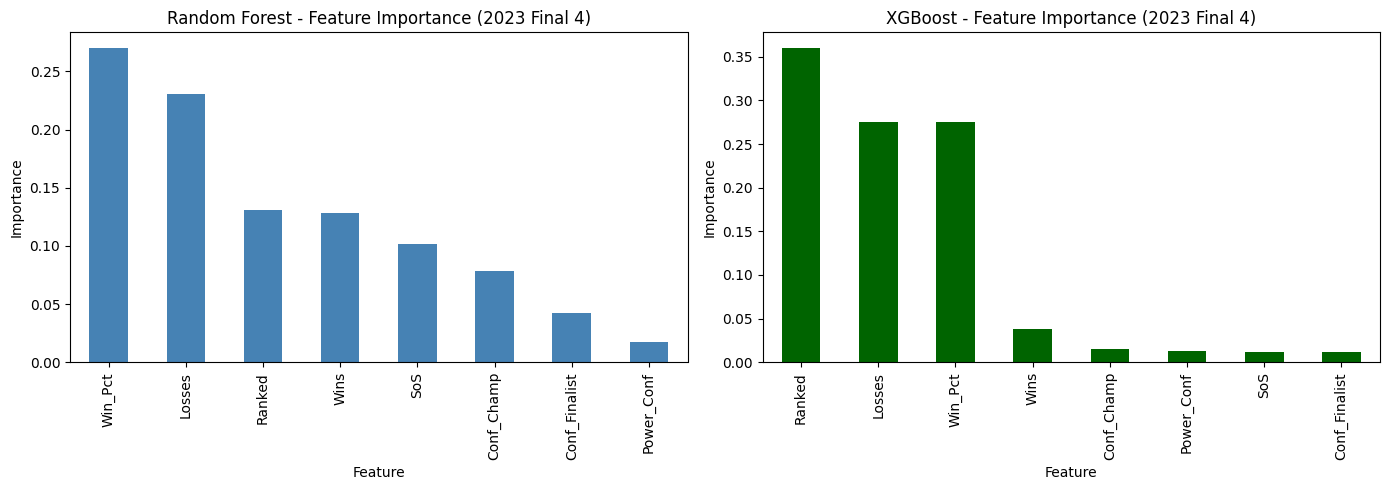

In [57]:
# Feature names
feature_names = ['Wins', 'Losses', 'SoS', 'Power_Conf', 'Ranked', 'Conf_Champ', 'Conf_Finalist', 'Win_Pct']

# Random Forest feature importance
rf_importance_2023 = pd.Series(rf_model_2023.feature_importances_, 
                                index=feature_names).sort_values(ascending=False)

# XGBoost feature importance
xgb_importance_2023 = pd.Series(xgb_model_2023.feature_importances_, 
                                 index=feature_names).sort_values(ascending=False)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

rf_importance_2023.plot.bar(ax=ax1, color='steelblue')
ax1.set_title('Random Forest - Feature Importance (2023 Final 4)')
ax1.set_ylabel('Importance')
ax1.set_xlabel('Feature')

xgb_importance_2023.plot.bar(ax=ax2, color='darkgreen')
ax2.set_title('XGBoost - Feature Importance (2023 Final 4)')
ax2.set_ylabel('Importance')
ax2.set_xlabel('Feature')

plt.tight_layout()
plt.show()

## Prediction 2: 2024 College Football Playoff (Final 12)

[Explain that 2024 was the first year of the expanded 12-team playoff. List the actual playoff teams.]

In [58]:
# Train models and get predictions for 2024 Final 12
rf_12_2024, rf_model_2024 = prediction(df, 2024, "Final_12", "RandomForest")
xgb_12_2024, xgb_model_2024 = prediction(df, 2024, "Final_12", "XGBoost")

# Actual 2024 playoff teams (first 12-team playoff)
actual_12_2024 = pd.DataFrame({
    "Rank": list(range(1, 19)),
    "Team": [
        "Oregon", "Georgia", "Texas", "Penn State", 
        "Notre Dame", "Ohio State", "Tennessee", "Indiana",
        "Boise State", "SMU", "Arizona State", "Clemson",
        
        "Alabama", "Miami (FL)", "Ole Miss",
        "South Carolina", "BYU", "Iowa State",
    ]
})

# Compare predictions to actual results
comp_12_2024, stats_12_2024 = compare_predictions(actual_12_2024, rf_12_2024, xgb_12_2024, n_teams=12, n_predict=18)

print("\n2024 College Football Playoff Predictions:")
print(comp_12_2024.head(12))
print("\n")
print(comp_12_2024.iloc[12:])
print("\n")
print_statistics(stats_12_2024)


2024 College Football Playoff Predictions:
             Team  Rank        RF Pred RF acc       XGB Pred XGB acc
0          Oregon     1         Oregon      0         Oregon       0
1         Georgia     2        Georgia      0  Arizona State      +9
2           Texas     3     Penn State     +1     Penn State      +1
3      Penn State     4  Arizona State     +7        Georgia      -2
4      Notre Dame     5        Clemson     +7     Miami (FL)      +9
5      Ohio State     6          Texas     -3        Clemson      +6
6       Tennessee     7     Miami (FL)     +7          Texas      -4
7         Indiana     8      Tennessee     -1     Ohio State      -2
8     Boise State     9     Iowa State     +9      Tennessee      -2
9             SMU    10            SMU      0     Iowa State      +8
10  Arizona State    11     Notre Dame     -6            SMU      -1
11        Clemson    12     Ohio State     -6       Colorado     N/A


              Team  Rank           RF Pred RF acc     XGB

### Feature Importance - 2024 Final 12 Models

[Discuss how feature importance may have changed with the expanded playoff format.]

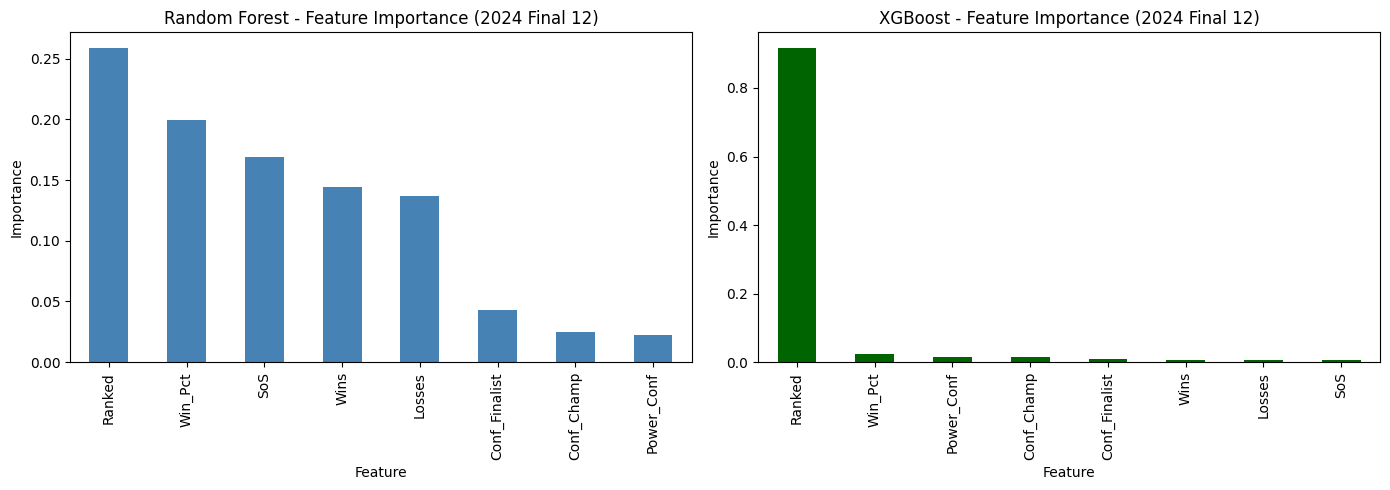

In [59]:
# Random Forest feature importance
rf_importance_2024 = pd.Series(rf_model_2024.feature_importances_, 
                                index=feature_names).sort_values(ascending=False)

# XGBoost feature importance
xgb_importance_2024 = pd.Series(xgb_model_2024.feature_importances_, 
                                 index=feature_names).sort_values(ascending=False)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

rf_importance_2024.plot.bar(ax=ax1, color='steelblue')
ax1.set_title('Random Forest - Feature Importance (2024 Final 12)')
ax1.set_ylabel('Importance')
ax1.set_xlabel('Feature')

xgb_importance_2024.plot.bar(ax=ax2, color='darkgreen')
ax2.set_title('XGBoost - Feature Importance (2024 Final 12)')
ax2.set_ylabel('Importance')
ax2.set_xlabel('Feature')

plt.tight_layout()
plt.show()

## Prediction 3: 2025 College Football Playoff (Final 12)

[This is the current season that just finished. Explain what makes this prediction interesting.]

In [60]:
# Train models and get predictions for 2025 Final 12
rf_12_2025, rf_model_2025 = prediction(df, 2025, "Final_12", "RandomForest")
xgb_12_2025, xgb_model_2025 = prediction(df, 2025, "Final_12", "XGBoost")

# Actual 2025 playoff teams
actual_12_2025 = pd.DataFrame({
    "Rank": list(range(1, 19)),
    "Team": [
        "Indiana", "Ohio State", "Georgia", "Texas Tech",
        "Oregon", "Ole Miss", "Texas A&M", "Oklahoma",
        "Alabama", "Miami (FL)", "Tulane", "James Madison",
        
        "Notre Dame", "BYU", "Texas", "Vanderbilt", "Utah", "USC"
    ]
})

# Compare predictions to actual results
comp_12_2025, stats_12_2025 = compare_predictions(actual_12_2025, rf_12_2025, xgb_12_2025, n_teams=12, n_predict=18)

print("\n2025 College Football Playoff Predictions:")
print(comp_12_2025.head(12))  # Show top 6
print('\n')  
print(comp_12_2025.iloc[12:])  # Show teams outside it

print("\n")
print_statistics(stats_12_2025)


2025 College Football Playoff Predictions:
             Team  Rank     RF Pred RF acc       XGB Pred XGB acc
0         Indiana     1     Georgia     +2        Georgia      +2
1      Ohio State     2         BYU    +12         Oregon      +3
2         Georgia     3  Ohio State     -1     Miami (FL)      +7
3      Texas Tech     4     Indiana     -3     Ohio State      -2
4          Oregon     5      Oregon      0            BYU      +9
5        Ole Miss     6   Texas A&M     +1       Oklahoma      +2
6       Texas A&M     7  Miami (FL)     +3     Notre Dame      +6
7        Oklahoma     8    Oklahoma      0        Indiana      -7
8         Alabama     9  Texas Tech     -5        Alabama       0
9      Miami (FL)    10  Notre Dame     +3      Texas A&M      -3
10         Tulane    11      Tulane      0         Tulane       0
11  James Madison    12    Ole Miss     -6  Arizona State     N/A


          Team  Rank        RF Pred RF acc    XGB Pred XGB acc
12  Notre Dame    13  James Madis

### Decision Tree Visualization - 2025 Final 12 Models

[Visualize a single decision tree from each model to see the actual decision rules being applied. This shows how the models make playoff predictions.]

In [61]:
from sklearn.tree import export_text

# Feature names for tree visualization
feature_names = ['Wins', 'Losses', 'SoS', 'Power_Conf', 'Ranked', 'Conf_Champ', 'Conf_Finalist', 'Win_Pct']

# Export Random Forest tree as text (first tree, limited depth)
print("Random Forest - Sample Decision Tree Rules (2025 Final 12):")
tree_rules_rf = export_text(rf_model_2025.estimators_[0],  # First tree
                             feature_names=feature_names,
                             max_depth=4)  # Limit depth for readability
print(tree_rules_rf)

Random Forest - Sample Decision Tree Rules (2025 Final 12):
|--- Conf_Finalist <= 0.50
|   |--- Ranked <= 0.50
|   |   |--- Losses <= 1.50
|   |   |   |--- class: 0.0
|   |   |--- Losses >  1.50
|   |   |   |--- class: 0.0
|   |--- Ranked >  0.50
|   |   |--- Win_Pct <= 0.76
|   |   |   |--- Losses <= 4.50
|   |   |   |   |--- Losses <= 3.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- Losses >  3.50
|   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |--- Losses >  4.50
|   |   |   |   |--- SoS <= 6.84
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- SoS >  6.84
|   |   |   |   |   |--- class: 0.0
|   |   |--- Win_Pct >  0.76
|   |   |   |--- SoS <= 0.31
|   |   |   |   |--- class: 0.0
|   |   |   |--- SoS >  0.31
|   |   |   |   |--- Win_Pct <= 0.78
|   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |--- Win_Pct >  0.78
|   |   |   |   |   |--- truncated branch of depth 7
|--- Conf_Finalist >  0.50
|   |--- SoS <= -4.77
|   |   |---

## Model Performance Comparison

[Compare Random Forest vs XGBoost performance across all predictions. Which model performed better overall?]

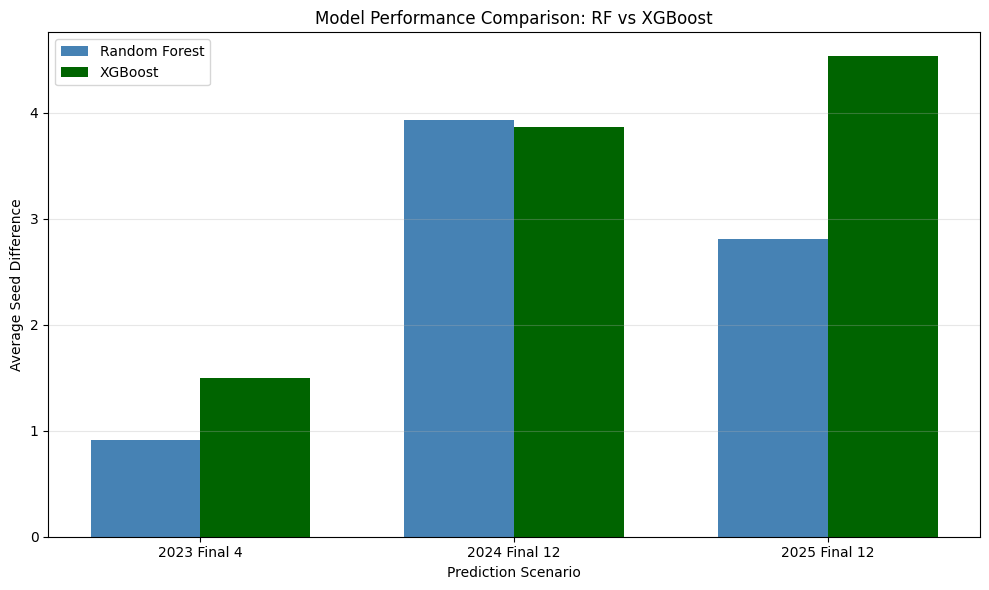

In [62]:
# Compare RF vs XGBoost average error across all predictions
comparison_data = {
    'Prediction': ['2023 Final 4', '2024 Final 12', '2025 Final 12'],
    'RF Avg Off': [
        stats_4_2023['rf_avg_off'],
        stats_12_2024['rf_avg_off'],
        stats_12_2025['rf_avg_off']
    ],
    'XGB Avg Off': [
        stats_4_2023['xgb_avg_off'],
        stats_12_2024['xgb_avg_off'],
        stats_12_2025['xgb_avg_off']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(comparison_df))
width = 0.35

ax.bar([i - width/2 for i in x], comparison_df['RF Avg Off'], 
       width, label='Random Forest', color='steelblue')
ax.bar([i + width/2 for i in x], comparison_df['XGB Avg Off'], 
       width, label='XGBoost', color='darkgreen')

ax.set_xlabel('Prediction Scenario')
ax.set_ylabel('Average Seed Difference')
ax.set_title('Model Performance Comparison: RF vs XGBoost')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Prediction'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Key Findings and Insights

[Summarize what you learned from this analysis. What patterns emerged? How well did the models perform? What surprised you?]

## Limitations and Future Work

[Be honest about what could be improved. Ideas for future iterations:
- Additional features (margin of victory, recent game trends, etc.)
- More sophisticated models
- Better handling of conference championship games
- Predicting actual playoff matchups
]